### 2021, 모델 해석이 포함된 인공지능 프로젝트
## (최종 수정된) Model-A 제작

In [ ]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import np_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# CIFAR-10 데이터 불러오기
from tensorflow.keras.datasets import cifar10

In [ ]:
# 데이터 할당
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape, "y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) y_test shape: (10000, 1)


In [ ]:
## 데이터 정규화: 0 ~ 255 -> 0.0 ~ 1.0 : 경사 하강법으로 신경망을 훈련하므로, 입력 특성의 스케일을 조정함
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_valid, X_train = X_train[:10000] / 255.0, X_train[10000:] / 255.0
y_valid, y_train = y_train[:10000], y_train[10000:]
X_test = X_test / 255.0

In [ ]:
# 레이어 쌓기
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2), padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2), padding='same'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2), padding='same'))
# 이 부분 이후부터 CAM을 위해 수정한 부분임. 원래는 Flat이후 Dense를 여러 번 거침.
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
# 옵티마이저 설정 및 컴파일, 모델 살피기
sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01/30, nesterov=False)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [ ]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid), batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 27s 670us/sample - loss: 2.3005 - accuracy: 0.1169 - val_loss: 2.2935 - val_accuracy: 0.1842
Epoch 2/30
40000/40000 [==============================] - 20s 497us/sample - loss: 2.1497 - accuracy: 0.1914 - val_loss: 2.0341 - val_accuracy: 0.2269
Epoch 3/30
40000/40000 [==============================] - 20s 510us/sample - loss: 2.0063 - accuracy: 0.2550 - val_loss: 1.9570 - val_accuracy: 0.2861
Epoch 4/30
40000/40000 [==============================] - 21s 513us/sample - loss: 1.9224 - accuracy: 0.2897 - val_loss: 1.8539 - val_accuracy: 0.3140
Epoch 5/30
40000/40000 [==============================] - 21s 519us/sample - loss: 1.8235 - accuracy: 0.3243 - val_loss: 1.7473 - val_accuracy: 0.3462
Epoch 6/30
40000/40000 [==============================] - 21s 526us/sample - loss: 1.7306 - accuracy: 0.3550 - val_loss: 1.6790 - val_accuracy: 0.3737
Epoch 7/30
40000/40000 [====================

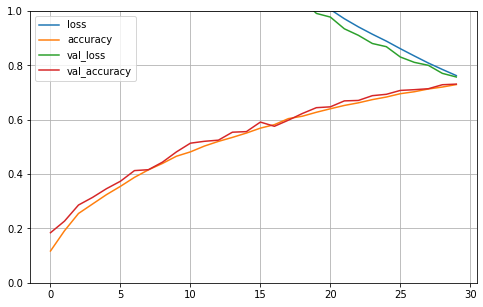

In [ ]:
# 로스와 정확도 그래프
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

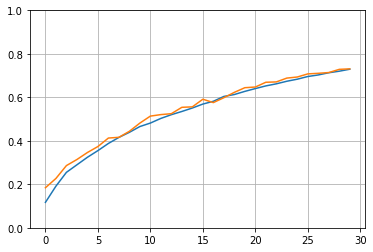

In [ ]:
# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

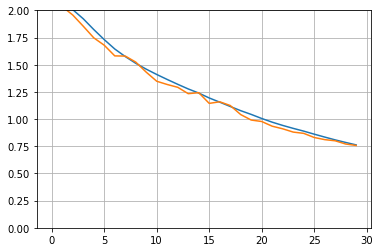

In [ ]:
# 로스 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [ ]:
# 모델 평가
model.evaluate(X_test, y_test) #test set으로 평가

10000/10000 [==============================] - 2s 205us/sample - loss: 0.7701 - accuracy: 0.7295


[0.770072510433197, 0.7295]

In [ ]:
# 테스트 완료된 모델 저장
from tensorflow.keras.models import load_model

model.save('Model-A_CIFAR10.h5')

# model 불러오기

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('Model-A_CIFAR10.h5')

In [ ]:
# Tensorflow Layer 확인
model.layers

# Seaborn 라이브러리를 통한 혼동행렬 구하기

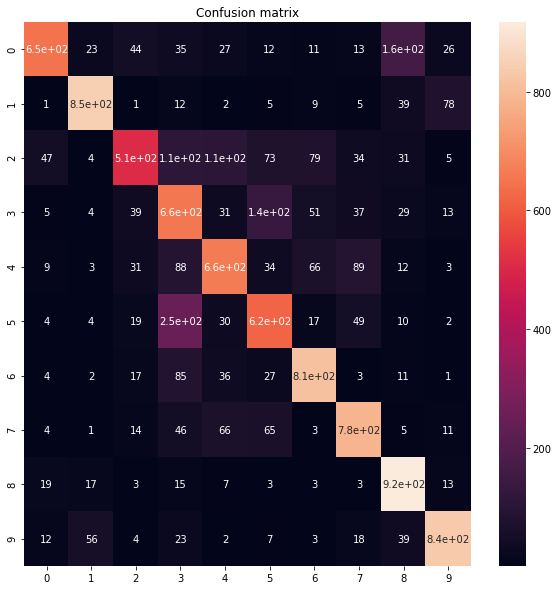

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model.predict(X_test)
pred_label = np.argmax(pred, axis = 1)

c_m = confusion_matrix(y_test, pred_label)
plt.figure(figsize=(10,10))
ax = plt.axes()
sns.heatmap(c_m, annot=True,
           annot_kws={"size": 10},
           ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# CIFAR-10 PCA 시각화 하기

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train.reshape((len(X_train),32*32*3)))

PCA(n_components=2)

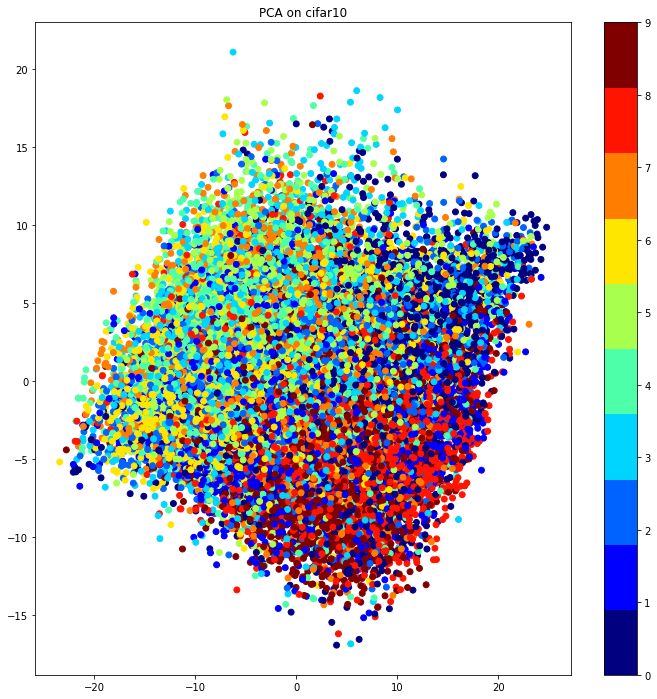

In [ ]:
from matplotlib import cm
plt.figure(figsize=(12,12))
cmap = cm.get_cmap('jet', 10)
plt.scatter(x=pca.transform(X_train.reshape((len(X_train),32*32*3)))[:,0],
            y=pca.transform(X_train.reshape((len(X_train),32*32*3)))[:,1],
            c=y_train.reshape(len(X_train)),s=35,cmap=cmap)
plt.title("PCA on cifar10")
plt.colorbar()
plt.show()

In [ ]:
latent_vector=model.predict(X_train)

In [ ]:
print(latent_vector.shape)
print(latent_vector[0])

(40000, 10)
[6.3187972e-04 9.6332157e-01 9.6149261e-06 6.2011030e-05 5.1163903e-07
 2.1300227e-06 4.2700191e-07 8.0239505e-07 1.7706816e-03 3.4200333e-02]


# 모델에 대한 예측 결과를 T-SNE로 시각화 하기

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=10, perplexity=100, random_state=0)
tsne_vector=tsne.fit_transform(latent_vector[:40000])

Wall time: 7min 24s


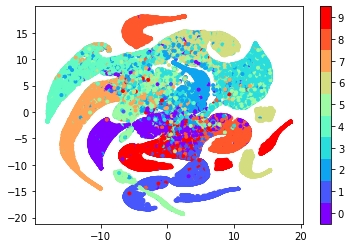

In [ ]:
# Perplexity 하나에 대해 진행, 데이터 세트는 유동적으로 조정

cmap = plt.get_cmap('rainbow', 10)
fig = plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=y_train[:40000], cmap=cmap)
cb = plt.colorbar(fig, ticks=range(10))
n_clusters = 10
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cb.set_ticks(tick_locs)
cb.set_ticklabels(range(10))

plt.show()

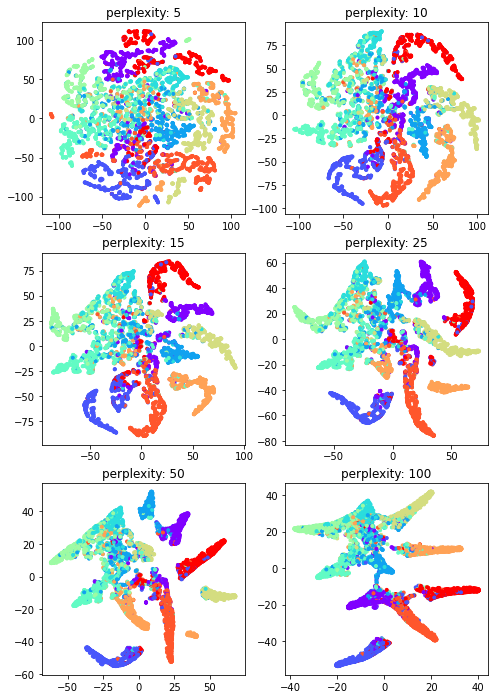

Wall time: 3min 6s


In [ ]:
%%time

# Perplexity 여러 개 진행, 데이터 세트는 유동적으로 조정
perplexities = [5, 10, 15, 25, 50, 100]
plt.figure(figsize=(8,12))

for c in range(6):
    tsne = TSNE(n_components=2, learning_rate=100, perplexity=perplexities[c], random_state=0)
    tsne_vector = tsne.fit_transform(latent_vector[:5000])

    plt.subplot(3, 2, c+1)
    plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=y_train[:5000], cmap='rainbow')
    plt.title('perplexity: {0}'.format(perplexities[c]))

plt.show()

In [ ]:
# Image to pass as input
img = tf.keras.preprocessing.image.load_img('./air.jpg', target_size=(32, 32))
img = tf.keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layer.name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

# Intermediate Feature Space - Layer Visualization

In [ ]:
# Intermediate Feature Space

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

img_path='./air.jpg'
# Define a new Model, Input= image
# Output= intermediate representations for all layers in the
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(32, 32))
# Convert ht image to Array of dimension (32,32,3)
x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all interm


# Intermediate Feature Space - Filter Visualization

conv2d
32


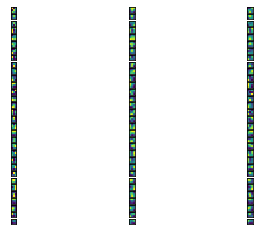

conv2d_1
32


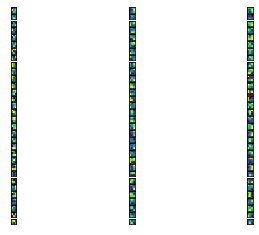

conv2d_2
64


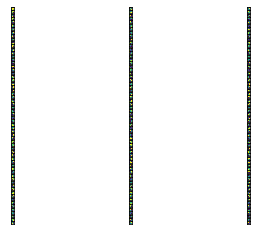

conv2d_3
64


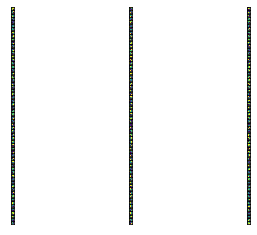

conv2d_4
128


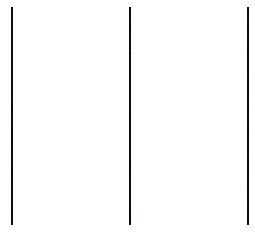

conv2d_5
128


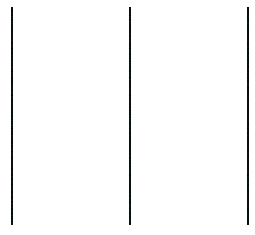

conv2d_6
256


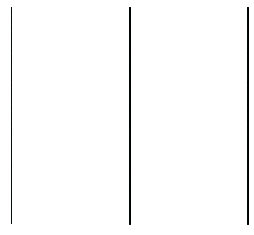

conv2d_7
256


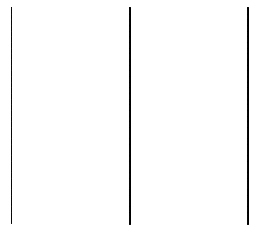

In [ ]:
# Visualize Filter or Feature Space

for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        #print(layer.name, filters.shape)
        print(layer.name)

        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(filters.shape[3])
        filter_cnt=1

        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

# CAM

In [ ]:
# CAM START
# Class Activation Map
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.python.keras.utils import np_utils
import pandas as pd
from numpy import argmax
from PIL import Image

In [ ]:
img = Image.open("air.jpg").resize((32, 32)) # 이미지 불러오기 및 resize
img_arr = np.asarray(img)[:, :, :3] / 255 # 정규화
img_array = np.expand_dims(img_arr, 0) # 입력 형태를 맞춰주기 위해 차원 추가, 즉 [1, 32, 32, 3] 형태임

In [ ]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img_array])
class_weights = model.layers[-1].get_weights()[0]

In [ ]:
output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0), #1, 256
                    np.transpose(np.reshape(conv_outputs[num],(4*4,256)))) #16, 256
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

In [ ]:
import cv2

cam = np.reshape(cam,(4,4)) # 2차원으로 변형
cam = (cam - np.min(cam))/(np.max(cam)-np.min(cam)) # 0~1 사이로 정규화
cam = np.expand_dims(np.uint8(255 * cam), axis=2) # 0 ~ 255 사이로 정규화 및 차원 추가
cam = cv2.applyColorMap(cv2.resize(cam, (750, 490)), cv2.COLORMAP_JET) #Imgae 픽셀 사이즈를 입력해야 함
# 컬러맵 처리 및 원본 이미지 크기와 맞춤
cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB) # RGB로 바꿈

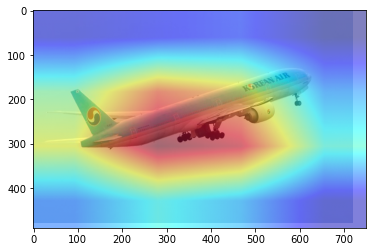

In [ ]:
img1 = Image.open("air.jpg")
img1_arr = np.asarray(img1)[:, :, :3] / 255
plt.imshow(img1_arr, alpha=1.0)
plt.imshow(cam, cmap='jet', alpha=0.5)

In [ ]:
# 모델이 해당 이미지에 대해 판별했을 때 판별율(가능성) 결과

ORIGINAL = 'air.jpg'
DIM = 32
img = cv2.imread(ORIGINAL)
try:
    img = cv2.resize(img, dsize=(DIM, DIM), interpolation=cv2.INTER_AREA)
except Exception as e:
        print(str(e))
#cv2.imshow('img',img)
#cv2.waitKey(0)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(preds)

[[9.9098599e-01 1.0632608e-03 3.8027824e-04 2.9218211e-03 5.1049636e-05
  1.7848978e-04 8.2377483e-05 2.2511074e-06 1.5495338e-04 4.1795899e-03]]
